In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import joblib
import pickle

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [2]:
# Movielens 25M dataset
movies_df = pd.read_csv('movielens/movies.csv')
ratings_df = pd.read_csv('movielens/ratings.csv')

In [3]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
movies_df.drop(columns='genres', inplace=True)

In [5]:
movies_df.shape

(62423, 2)

In [6]:
len(movies_df.movieId.unique())

62423

In [7]:
movies_df.isnull().sum()

movieId    0
title      0
dtype: int64

In [8]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [9]:
ratings_df.drop(columns='timestamp', inplace=True)

In [10]:
ratings_df.shape

(25000095, 3)

In [11]:
ratings_df.nunique()

userId     162541
movieId     59047
rating         10
dtype: int64

In [12]:
# We notice more than 162,000 unique users and 59,047 movies represented in the 
# ratings data. This means that there exists titles in the movies_df that do not
# have ratings data associated with them; we will drop these records.

# We're only interested in rating and movie metadata (excluding genre)
main_df = pd.merge(
    ratings_df[['userId', 'movieId', 'rating']],
    movies_df[['movieId', 'title']],
    how='left',
    on='movieId'
)

In [13]:
# Taking a quick look
main_df.head()

,userId,movieId,rating,title
0,1,296,5.0,Pulp Fiction (1994)
1,1,306,3.5,Three Colors: Red (Trois couleurs: Rouge) (1994)
2,1,307,5.0,Three Colors: Blue (Trois couleurs: Bleu) (1993)
3,1,665,5.0,Underground (1995)
4,1,899,3.5,Singin' in the Rain (1952)


In [14]:
# Calculate how many movies each user has submitted a rating for. This will be
# used later to filter out users with a low number of ratings
user_ratings_df = ratings_df.groupby('userId')['rating'].count().reset_index()
user_ratings_df.rename(columns={'rating':'NoMoviesRated'}, inplace=True)

user_list = user_ratings_df[user_ratings_df.NoMoviesRated>=100]['userId'].to_list()
user_list = random.sample(user_list, 30000)
len(user_list)

30000

In [15]:
# Create new dataframes for average rating and total number of ratings per title
avg_ratings_df = ratings_df.groupby('movieId')['rating'].mean().reset_index()
avg_ratings_df.rename(columns={'rating':'AvgRating'}, inplace=True)

count_ratings_df = ratings_df.groupby('movieId')['rating'].count().reset_index()
count_ratings_df.rename(columns={'rating':'CountRating'}, inplace=True)

ratings_metrics_df = pd.merge(
    avg_ratings_df,
    count_ratings_df,
    how='left',
    on='movieId'
)

Text(0, 0.5, 'Rating Count')

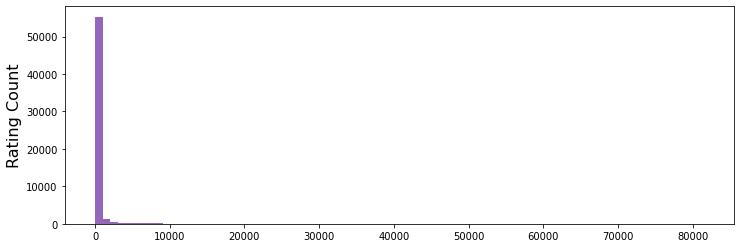

In [16]:
plt.figure(figsize=(12,4))
plt.hist(count_ratings_df.CountRating,bins=80,color='tab:purple')
plt.ylabel('Rating Count', fontsize=16)

In [17]:
final_df = pd.merge(
    main_df[main_df.userId.isin(user_list)],  # Filter using user_list
    ratings_metrics_df,
    how='left',
    on='movieId'
)

# Only consider those movies with at least 100 ratings
truncated_final_df = final_df[final_df.CountRating>=100]

In [18]:
truncated_final_df.sort_values(by='CountRating', ascending=False)

,userId,movieId,rating,title,AvgRating,CountRating
5578907,93864,356,5.0,Forrest Gump (1994),4.048011,81491
3905648,66019,356,4.0,Forrest Gump (1994),4.048011,81491
213996,4039,356,4.0,Forrest Gump (1994),4.048011,81491
938598,16649,356,5.0,Forrest Gump (1994),4.048011,81491
3375181,57276,356,4.5,Forrest Gump (1994),4.048011,81491
...,...,...,...,...,...,...
6667544,112556,94841,3.0,Hick (2011),3.090000,100
2132659,35930,5256,2.0,Stolen Summer (2002),3.035000,100
3659191,61869,98087,1.5,Cockneys vs Zombies (2012),2.945000,100
752640,13438,94841,4.0,Hick (2011),3.090000,100


In [19]:
# We still have too many records to be able to train our model with our current 
# memory limitations. Let's try to bring the size of this dataframe down.

# First, let's take a look at how many unique movies are represented currently 
# in the data.
len(truncated_final_df.movieId.unique())

10326

In [20]:
features_df = truncated_final_df.pivot(
    index='movieId',
    columns='userId',
    values='rating'
    ).fillna(0)

In [21]:
features_df

userId,13,18,19,23,43,46,69,76,86,89,...,162501,162504,162507,162508,162516,162521,162524,162529,162537,162541
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,3.0,0.0,0.0,4.0,0.0,3.0,0.0,5.0,0.0,...,0.0,0.0,4.0,4.5,4.5,4.0,4.5,2.0,0.0,0.0
2,0.0,0.0,3.5,0.0,3.5,0.0,0.0,0.0,3.0,3.0,...,0.0,0.0,3.0,0.0,2.5,0.0,0.0,4.0,0.0,0.0
3,0.0,1.5,0.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,2.0,4.0,0.0,0.5,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
5,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
features_df_pre_reset = features_df

In [23]:
features_matrix = csr_matrix(features_df.values)
features_df.reset_index(inplace=True)
model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model.fit(features_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [29]:
link_df = pd.read_csv('movielens/link.csv')[['movieId', 'tmdbId']]

In [76]:
def recommend(title):
    n_movies_to_recommend = 10
    movie_list = truncated_final_df[truncated_final_df['title'].str.contains(title, case=False)].head(1)  
    if len(movie_list):
        found_title = movie_list.iloc[0]['title']        
        movie_idx = movie_list.iloc[0]['movieId']
        movie_idx = features_df[features_df['movieId']==movie_idx].index[0]

        distances, indices = model.kneighbors(features_matrix[movie_idx],n_neighbors=n_movies_to_recommend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        rec_movie_indices.reverse()
        
        res = []

        for val in rec_movie_indices:
          movie_idx = features_df.iloc[val[0]]['movieId']
          idx = truncated_final_df[truncated_final_df['movieId'] == movie_idx].iloc[0]['title']
          try:
            tmdb = link_df[link_df['movieId']==movie_idx]['tmdbId'].iloc[0]
          except:
            tmdb = np.nan
          res.append(
              {'Title':idx, 'Distance':val[1], 'tmdbId':tmdb}
          )
        
        print(found_title)
        res = pd.DataFrame(res)
        return res
    else:
        return "No movies found. Please try again with a different title."

In [81]:
recommend('inception')

Inception (2010)


,Title,Distance,tmdbId
0,"Dark Knight, The (2008)",0.217647,155.0
1,Interstellar (2014),0.277964,157336.0
2,"Dark Knight Rises, The (2012)",0.278636,49026.0
3,Inglourious Basterds (2009),0.282665,16869.0
4,Shutter Island (2010),0.287717,11324.0
5,Avatar (2009),0.290457,19995.0
6,Django Unchained (2012),0.308094,68718.0
7,WALL·E (2008),0.315310,10681.0
8,Up (2009),0.316010,14160.0
9,Iron Man (2008),0.319848,1726.0


In [80]:
truncated_final_df.to_csv('collab-model-final-df.csv')